In [ ]:
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [ ]:
!pip install kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d dhoogla/unswnb15 -q
!unzip -q unswnb15.zip

Dataset URL: https://www.kaggle.com/datasets/dhoogla/unswnb15
License(s): CC-BY-NC-SA-4.0


In [ ]:
!kaggle datasets download -d aryashah2k/nfuqnidsv2-network-intrusion-detection-dataset -q
!unzip -q nfuqnidsv2-network-intrusion-detection-dataset.zip

Dataset URL: https://www.kaggle.com/datasets/aryashah2k/nfuqnidsv2-network-intrusion-detection-dataset
License(s): CC0-1.0


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import matplotlib.pyplot as plt

UNSW-NB15 Preprocessing

In [ ]:

unsw = pd.read_parquet('UNSW_NB15_training-set.parquet')

# Drop unnecessary columns
unsw.drop(columns=[c for c in ['srcip', 'dstip', 'sport', 'dsport', 'stime', 'ltime'] if c in unsw.columns],
           inplace=True)

# Label encode categorical features
for col in ['proto', 'service', 'state']:
    if col in unsw.columns:
        le = LabelEncoder()
        unsw[col] = le.fit_transform(unsw[col].astype(str))

# Handle missing labels and encode attack labels
unsw['attack_cat'] = unsw['attack_cat'].fillna('Normal')
le_attack = LabelEncoder()
unsw['label_encoded'] = le_attack.fit_transform(unsw['attack_cat'])

# Drop original label column
if 'attack_cat' in unsw.columns:
    unsw.drop(columns=['attack_cat'], inplace=True)

# Replace inf/nan
unsw = unsw.replace([float('inf'), -float('inf')], np.nan).dropna()

# Scale numeric features
numeric_cols_unsw = unsw.select_dtypes(include=['int64','float64']).columns.tolist()
numeric_cols_unsw = [c for c in numeric_cols_unsw if c != 'label_encoded']
scaler = MinMaxScaler()
unsw[numeric_cols_unsw] = scaler.fit_transform(unsw[numeric_cols_unsw])

# Save client 1
unsw.to_csv("/content/client1_UNSW.csv", index=False)
print("UNSW dataset saved as client1_UNSW.csv")

UNSW dataset saved as client1_UNSW.csv


NF-UQ-NIDS-v2 Preprocessing + Manual Mapping

In [ ]:

nfq = pd.read_csv("NF-UQ-NIDS-v2.csv", nrows=200000)
nfq = nfq.sample(n=175341, random_state=42).reset_index(drop=True)

# Drop unnecessary columns
nfq.drop(columns=[c for c in ['Flow ID', 'Source IP', 'Destination IP',
                              'Src Port', 'Dst Port', 'Timestamp',
                              'StartTime', 'EndTime'] if c in nfq.columns],
         inplace=True)

# Label encode categorical features
for col in ['proto', 'service', 'state']:
    if col in nfq.columns:
        le = LabelEncoder()
        nfq[col] = le.fit_transform(nfq[col].astype(str))

# Encode attack labels
nfq['Attack'] = nfq['Attack'].replace('Benign', 'Normal').fillna('Normal')
base_mapping = dict(zip(le_attack.classes_, le_attack.transform(le_attack.classes_)))
current_max = max(base_mapping.values())
for att in nfq['Attack'].unique():
    if att not in base_mapping:
        current_max += 1
        base_mapping[att] = current_max
nfq['label_encoded'] = nfq['Attack'].map(base_mapping).astype(int)

# Drop original attack column
if 'Attack' in nfq.columns:
    nfq.drop(columns=['Attack'], inplace=True)

if 'FLOW_DURATION_MILLISECONDS' in nfq.columns:
    nfq['FLOW_DURATION_MILLISECONDS'] = nfq['FLOW_DURATION_MILLISECONDS'] / 1000


#  Manual Feature Mapping
# Map NFQ columns to UNSW-style features
mapping = {
    'FLOW_DURATION_MILLISECONDS': 'dur',
    'PROTOCOL': 'proto',
    'IN_PKTS': 'spkts',
    'OUT_PKTS': 'dpkts',
    'IN_BYTES': 'sbytes',
    'OUT_BYTES': 'dbytes',
    'SRC_TO_DST_AVG_THROUGHPUT': 'sload',
    'DST_TO_SRC_AVG_THROUGHPUT': 'dload',
    'RETRANSMITTED_IN_BYTES': 'sloss',
    'RETRANSMITTED_OUT_BYTES': 'dloss',
    'LONGEST_FLOW_PKT': 'sinpkt',
    'SHORTEST_FLOW_PKT': 'dinpkt',
    'TCP_WIN_MAX_OUT': 'dwin',
    'TCP_WIN_MAX_IN': 'swin',
    'IPV4_SRC_ADDR': 'srcip',
    'L4_SRC_PORT': 'srcport',
    'IPV4_DST_ADDR':'dstip',
    'L4_DST_PORT': 'dstport',
    'L7_PROTO': 'service',
    'TCP_FLAGS': 'state',
}

nfq.rename(columns=mapping, inplace=True)

# Keep only columns that exist in UNSW + label_encoded
common_features = [c for c in unsw.columns if c != 'label_encoded' and c in nfq.columns]

# Drop columns in NFQ that are not mapped
nfq = nfq[common_features + ['label_encoded']]

# Scale numeric features
numeric_cols_nfq = nfq.select_dtypes(include=['int64','float64']).columns.tolist()
numeric_cols_nfq = [c for c in numeric_cols_nfq if c != 'label_encoded']
nfq[numeric_cols_nfq] = scaler.fit_transform(nfq[numeric_cols_nfq])

# Save client 2
nfq.to_csv("/content/client2_NFQ.csv", index=False)
print("NF-UQ dataset saved as client2_NFQ.csv")

NF-UQ dataset saved as client2_NFQ.csv



Unified Attack Mapping for Multi-class Classification

In [ ]:


# Define broader unified attack categories
attack_mapping_unified = {
    # Normal traffic
    'Normal': 'Normal',
    'Benign': 'Normal',

    # Denial of Service
    'DoS': 'DoS',
    'DDoS': 'DoS',
    'DoS GoldenEye': 'DoS',
    'DoS Hulk': 'DoS',
    'DoS Slowhttptest': 'DoS',
    'DoS Slowloris': 'DoS',
    'Service DoS': 'DoS',

    # Scanning & Reconnaissance
    'Reconnaissance': 'Reconnaissance',
    'PortScan': 'Reconnaissance',
    'Scanning': 'Reconnaissance',
    'Fuzzers': 'Reconnaissance',

    # Exploits / Injection
    'Exploits': 'Exploits',
    'Shellcode': 'Exploits',
    'Worms': 'Exploits',
    'Backdoor': 'Exploits',
    'Generic': 'Exploits',
    'SQL Injection': 'Exploits',
    'Command Injection': 'Exploits',
    'Code Injection': 'Exploits',

    # Information Theft
    'Theft': 'Theft',
    'Data Exfiltration': 'Theft',
    'Data Theft': 'Theft',
    'Information Gathering': 'Theft',

    # Web-based Attacks
    'Web Attack': 'Web Attack',
    'Brute Force': 'Web Attack',
    'Cross Site Scripting': 'Web Attack',
    'XSS': 'Web Attack',
    'Infiltration': 'Web Attack',

    # Generic Malware
    'Trojan': 'Malware',
    'Virus': 'Malware',
    'Botnet': 'Malware',
    'Malware': 'Malware',
}

# ---------------------------------------------------
# Apply unified mapping to UNSW dataset
# ---------------------------------------------------
if 'label_encoded' in unsw.columns:
    # Need to recover original label names temporarily
    unsw_labels = le_attack.inverse_transform(unsw['label_encoded'])
    unsw['UnifiedAttack'] = [attack_mapping_unified.get(a, 'Other') for a in unsw_labels]

# Apply unified mapping to NF-UQ dataset

if 'label_encoded' in nfq.columns:
    # If NFQ was mapped via base_mapping, get inverse
    inv_base_mapping = {v: k for k, v in base_mapping.items()}
    nfq_labels = [inv_base_mapping.get(a, 'Normal') for a in nfq['label_encoded']]
    nfq['UnifiedAttack'] = [attack_mapping_unified.get(a, 'Other') for a in nfq_labels]

# Encode unified labels for both datasets consistently
all_labels = list(set(unsw['UnifiedAttack'].unique()).union(set(nfq['UnifiedAttack'].unique())))
le_unified = LabelEncoder()
le_unified.fit(all_labels)

unsw['label_encoded'] = le_unified.transform(unsw['UnifiedAttack'])
nfq['label_encoded'] = le_unified.transform(nfq['UnifiedAttack'])

# Update base mapping with unified labels
base_mapping = dict(zip(le_unified.classes_, le_unified.transform(le_unified.classes_)))

print("Unified Attack Mapping:")
for k, v in base_mapping.items():
    print(f"{v}: {k}")

# Drop helper columns
unsw.drop(columns=['UnifiedAttack'], inplace=True)
nfq.drop(columns=['UnifiedAttack'], inplace=True)


Unified Attack Mapping:
0: DoS
1: Exploits
2: Normal
3: Other
4: Reconnaissance
5: Theft
6: Web Attack


Print attack types and sample counts across both datasets

In [ ]:

# Count samples per attack type in both datasets
unsw_counts = unsw['label_encoded'].value_counts().rename_axis('label_encoded').reset_index(name='UNSW_count')
nfq_counts = nfq['label_encoded'].value_counts().rename_axis('label_encoded').reset_index(name='NFQ_count')

# Merge counts by label
attack_counts = pd.merge(unsw_counts, nfq_counts, on='label_encoded', how='outer').fillna(0)

# Map label codes to class names using base_mapping
inv_base_mapping = {v: k for k, v in base_mapping.items()}
attack_counts['Attack_Type'] = attack_counts['label_encoded'].map(inv_base_mapping)

# Add combined total count
attack_counts['Total_Samples'] = attack_counts['UNSW_count'] + attack_counts['NFQ_count']

# Reorder columns for readability
attack_counts = attack_counts[['Attack_Type', 'label_encoded', 'UNSW_count', 'NFQ_count', 'Total_Samples']]

# Sort by total samples (descending)
attack_counts = attack_counts.sort_values(by='Total_Samples', ascending=False).reset_index(drop=True)

print("\n===== Attack Label Distribution Across Datasets =====")
print(attack_counts.to_string(index=False))
print("=====================================================")



===== Attack Label Distribution Across Datasets =====
   Attack_Type  label_encoded  UNSW_count  NFQ_count  Total_Samples
        Normal              2     56000.0      57609       113609.0
           DoS              0     12264.0      91913       104177.0
      Exploits              1     76402.0        143        76545.0
Reconnaissance              4     28675.0       6103        34778.0
         Other              3      2000.0      19272        21272.0
    Web Attack              6         0.0        298          298.0
         Theft              5         0.0          3            3.0


Remove 'Theft' class and reindex labels consistently

In [ ]:

#  Remove 'Theft' samples if present
if 'Theft' in base_mapping:
    theft_label = base_mapping['Theft']

    # Filter out Theft samples
    unsw = unsw[unsw['label_encoded'] != theft_label].reset_index(drop=True)
    nfq = nfq[nfq['label_encoded'] != theft_label].reset_index(drop=True)

    print(f"Removed 'Theft' attacks (label code = {theft_label}) from both datasets.")
else:
    print("No 'Theft' label found — skipping removal.")

#  Reindex remaining labels
# Extract all unique labels from both datasets
unique_labels = sorted(list(set(unsw['label_encoded'].unique()) | set(nfq['label_encoded'].unique())))

# Create a new sequential mapping (0,1,2,...)
new_label_mapping = {old: new for new, old in enumerate(unique_labels)}

# Apply new mapping
unsw['label_encoded'] = unsw['label_encoded'].map(new_label_mapping)
nfq['label_encoded'] = nfq['label_encoded'].map(new_label_mapping)

#  Update base_mapping to reflect new indices
inv_base_mapping = {v: k for k, v in base_mapping.items()}
base_mapping = {inv_base_mapping[old]: new for old, new in new_label_mapping.items() if old in inv_base_mapping}

#  Print updated label summary
print("\n Final Unified Attack Mapping (after removing Theft & reindexing):")
for k, v in base_mapping.items():
    print(f"{v}: {k}")

#  Optional: Display new label counts
print("\nUpdated label distribution:")
unsw_counts = unsw['label_encoded'].value_counts().sort_index()
nfq_counts = nfq['label_encoded'].value_counts().sort_index()
for lbl in sorted(base_mapping.values()):
    attack_name = [k for k, v in base_mapping.items() if v == lbl][0]
    print(f"{attack_name:<15} | UNSW: {unsw_counts.get(lbl,0):<6} | NFQ: {nfq_counts.get(lbl,0):<6}")


Removed 'Theft' attacks (label code = 5) from both datasets.

✅ Final Unified Attack Mapping (after removing Theft & reindexing):
0: DoS
1: Exploits
2: Normal
3: Other
4: Reconnaissance
5: Web Attack

Updated label distribution:
DoS             | UNSW: 12264  | NFQ: 91913 
Exploits        | UNSW: 76402  | NFQ: 143   
Normal          | UNSW: 56000  | NFQ: 57609 
Other           | UNSW: 2000   | NFQ: 19272 
Reconnaissance  | UNSW: 28675  | NFQ: 6103  
Web Attack      | UNSW: 0      | NFQ: 298   


 Re-encode labels

In [ ]:

le = LabelEncoder()
all_labels = pd.concat([unsw['label_encoded'], nfq['label_encoded']])
le.fit(all_labels)
unsw['label_encoded'] = le.transform(unsw['label_encoded'])
nfq['label_encoded'] = le.transform(nfq['label_encoded'])

Normalize features per client

In [ ]:

common_features = [c for c in unsw.columns if c != 'label_encoded' and c in nfq.columns]
scaler1 = MinMaxScaler()
scaler2 = MinMaxScaler()
X1 = pd.DataFrame(scaler1.fit_transform(unsw[common_features]), columns=common_features)
X2 = pd.DataFrame(scaler2.fit_transform(nfq[common_features]), columns=common_features)
y1 = unsw['label_encoded'].copy()
y2 = nfq['label_encoded'].copy()

In [ ]:
import os
import random
import tensorflow as tf
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

 Stratified Train/Test Split

In [ ]:

from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=SEED)
X1_np, y1_np = X1.values.astype('float32'), y1.values.astype('int32')
X2_np, y2_np = X2.values.astype('float32'), y2.values.astype('int32')

train_idx1, test_idx1 = next(sss.split(X1_np, y1_np))
train_idx2, test_idx2 = next(sss.split(X2_np, y2_np))

X1_train, X1_test = X1_np[train_idx1], X1_np[test_idx1]
y1_train, y1_test = y1_np[train_idx1], y1_np[test_idx1]
X2_train, X2_test = X2_np[train_idx2], X2_np[test_idx2]
y2_train, y2_test = y2_np[train_idx2], y2_np[test_idx2]

num_classes = len(le.classes_)

In [ ]:
print("Train set class counts:")
print(pd.Series(y1_train.tolist() + y2_train.tolist()).value_counts().sort_index())

print("\nTest set class counts:")
print(pd.Series(y1_test.tolist() + y2_test.tolist()).value_counts().sort_index())


Train set class counts:
0    83341
1    61236
2    90887
3    17018
4    27822
5      238
Name: count, dtype: int64

Test set class counts:
0    20836
1    15309
2    22722
3     4254
4     6956
5       60
Name: count, dtype: int64


FedProx Implementation

In [ ]:

import os, random, numpy as np, tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, precision_recall_curve, auc


In [ ]:
ROUNDS = 15
LOCAL_EPOCHS = 4
BATCH_SIZE = 128
MU = 0.01
LEARNING_RATE = 1e-4

Model Definition

In [ ]:

def create_model(input_dim, num_classes):
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(input_dim,)),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

FedProx Local Training

In [ ]:

def client_train_fedprox(X, y, global_weights, num_classes, epochs=LOCAL_EPOCHS, batch_size=BATCH_SIZE, mu=MU):

    #Local training for FedProx:
    #Adds proximal term to keep local model close to the global weights.

    local_model = create_model(X.shape[1], num_classes)
    local_model.set_weights(global_weights)

    optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()

    # Convert global weights to tensors once
    global_weights_tf = [tf.convert_to_tensor(w, dtype=tf.float32) for w in global_weights]

    # Create dataset
    train_ds = tf.data.Dataset.from_tensor_slices((X, y)).shuffle(1024, seed=SEED).batch(batch_size)

    for epoch in range(epochs):
        epoch_loss = 0.0
        for step, (x_batch, y_batch) in enumerate(train_ds):
            with tf.GradientTape() as tape:
                y_pred = local_model(x_batch, training=True)
                loss = loss_fn(y_batch, y_pred)

                #  FedProx regularization term (match by shape)
                prox_term = tf.add_n([
                    tf.reduce_sum(tf.square(w - w_global))
                    for w, w_global in zip(local_model.trainable_weights, global_weights_tf)
                    if w.shape == w_global.shape  # prevent shape mismatch
                ])
                loss += (mu / 2.0) * prox_term

            grads = tape.gradient(loss, local_model.trainable_weights)
            optimizer.apply_gradients(zip(grads, local_model.trainable_weights))
            epoch_loss += loss.numpy()

        print(f"Client local epoch {epoch+1}/{epochs}, loss={epoch_loss/len(train_ds):.4f}")

    acc = local_model.evaluate(X, y, verbose=0)[1]
    return local_model.get_weights(), len(y), acc


Server Aggregation

In [ ]:

def fed_weighted_avg(weights_list, sizes):
    total = np.sum(sizes)
    new_weights = []
    for i in range(len(weights_list[0])):
        layer_stack = np.stack([w[i] for w in weights_list], axis=0)
        new_weights.append(np.tensordot(sizes / total, layer_stack, axes=([0], [0])))
    return new_weights

Federated Training Loop (FedProx)

In [ ]:

results = []
global_model = create_model(X1_train.shape[1], num_classes)
global_weights = global_model.get_weights()

for r in range(ROUNDS):
    print(f"\n --- Federated Round {r+1}/{ROUNDS} ---")

    client_weights, client_sizes, client_accs = [], [], []

    # ---- Client 1 ----
    w1, n1, acc1 = client_train_fedprox(
        X1_train, y1_train, global_weights, num_classes,
        epochs=LOCAL_EPOCHS, batch_size=BATCH_SIZE, mu=MU
    )
    client_weights.append(w1)
    client_sizes.append(n1)
    client_accs.append(acc1)
    print(f"Client 1 Accuracy: {acc1:.4f}")

    # ---- Client 2 ----
    w2, n2, acc2 = client_train_fedprox(
        X2_train, y2_train, global_weights, num_classes,
        epochs=LOCAL_EPOCHS, batch_size=BATCH_SIZE, mu=MU
    )
    client_weights.append(w2)
    client_sizes.append(n2)
    client_accs.append(acc2)
    print(f"Client 2 Accuracy: {acc2:.4f}")

    # ---- Server Aggregation ----
    global_weights = fed_weighted_avg(client_weights, np.array(client_sizes))
    global_model.set_weights(global_weights)

    global_train_acc = np.average(client_accs, weights=client_sizes)
    print(f"  Global Weighted Training Accuracy: {global_train_acc:.4f}")

    results.append([r+1, acc1, acc2, global_train_acc])



 --- Federated Round 1/15 ---
Client local epoch 1/4, loss=1.0661
Client local epoch 2/4, loss=0.8370
Client local epoch 3/4, loss=0.7940
Client local epoch 4/4, loss=0.7764
Client 1 Accuracy: 0.6940
Client local epoch 1/4, loss=0.6649
Client local epoch 2/4, loss=0.4510
Client local epoch 3/4, loss=0.3907
Client local epoch 4/4, loss=0.3585
Client 2 Accuracy: 0.9024
  Global Weighted Training Accuracy: 0.7982

 --- Federated Round 2/15 ---
Client local epoch 1/4, loss=0.8381
Client local epoch 2/4, loss=0.7736
Client local epoch 3/4, loss=0.7563
Client local epoch 4/4, loss=0.7489
Client 1 Accuracy: 0.7053
Client local epoch 1/4, loss=0.4318
Client local epoch 2/4, loss=0.3443
Client local epoch 3/4, loss=0.3161
Client local epoch 4/4, loss=0.2984
Client 2 Accuracy: 0.9142
  Global Weighted Training Accuracy: 0.8097

 --- Federated Round 3/15 ---
Client local epoch 1/4, loss=0.8002
Client local epoch 2/4, loss=0.7515
Client local epoch 3/4, loss=0.7388
Client local epoch 4/4, loss=0.

Evaluation on Test Data

In [ ]:


#  Combine training data for fine-tuning
X_train_all = np.concatenate([X1_train, X2_train])
y_train_all = np.concatenate([y1_train, y2_train])

print("\n--- Fine-tuning global model on combined training data ---")
global_model.fit(X_train_all, y_train_all, epochs=2, batch_size=128, verbose=1)

# Evaluate on test set
X_test_all = np.concatenate([X1_test, X2_test])
y_test_all = np.concatenate([y1_test, y2_test])

loss, acc = global_model.evaluate(X_test_all, y_test_all, verbose=0)
print(f"\n Combined Global Accuracy after fine-tuning: {acc:.4f}")



--- Fine-tuning global model on combined training data ---
Epoch 1/2
2192/2192 ━━━━━━━━━━━━━━━━━━━━ 27s 10ms/step - accuracy: 0.8008 - loss: 0.4882
Epoch 2/2
2192/2192 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - accuracy: 0.8274 - loss: 0.4255

 Combined Global Accuracy after fine-tuning: 0.8535


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, precision_recall_curve, auc

def evaluate_global_model(model, X_test, y_test):
    y_pred_prob = model.predict(X_test)
    y_pred = np.argmax(y_pred_prob, axis=1)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    rec = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted')

    # ROC-AUC (multiclass)
    try:
        roc_auc = roc_auc_score(tf.keras.utils.to_categorical(y_test), y_pred_prob, multi_class='ovr')
    except:
        roc_auc = None

    # PR-AUC (macro)
    try:
        precision, recall, _ = precision_recall_curve(y_test, y_pred_prob[:,1])
        pr_auc = auc(recall, precision)
    except:
        pr_auc = None

    cm = confusion_matrix(y_test, y_pred)

    print(f"\n Final Evaluation Metrics:")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}" if roc_auc else "ROC AUC: N/A")
    print(f"PR AUC: {pr_auc:.4f}" if pr_auc else "PR AUC: N/A")
    print(f"Confusion Matrix:\n{cm}")

    return {
        "accuracy": acc, "precision": prec, "recall": rec, "f1": f1,
        "roc_auc": roc_auc, "pr_auc": pr_auc, "confusion_matrix": cm
    }


Saving all csv files

In [ ]:
y1_pred = global_model.predict(X1_test)
y2_pred = global_model.predict(X2_test)

if y1_pred.ndim > 1:
    y1_pred = np.argmax(y1_pred, axis=1)
    y2_pred = np.argmax(y2_pred, axis=1)

# Make DataFrames for comparison
df1 = pd.DataFrame(X1_test, columns=[f"feature_{i}" for i in range(X1_test.shape[1])])
df1["Expected_Label"] = y1_test
df1["Predicted_Label"] = y1_pred

df2 = pd.DataFrame(X2_test, columns=[f"feature_{i}" for i in range(X2_test.shape[1])])
df2["Expected_Label"] = y2_test
df2["Predicted_Label"] = y2_pred

# Save to CSV files
df1.to_csv("Client1_Test_Predictions1.csv", index=False)
df2.to_csv("Client2_Test_Predictions1.csv", index=False)

print(" Saved Client1_Test_Predictions.csv and Client2_Test_Predictions.csv successfully.")


1096/1096 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
1096/1096 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
 Saved Client1_Test_Predictions.csv and Client2_Test_Predictions.csv successfully.


In [ ]:
from google.colab import files

files.download("/content/Client1_Test_Predictions1.csv")
files.download("/content/Client2_Test_Predictions1.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
evaluate_global_model(global_model,X_test_all,y_test_all)

2192/2192 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step

📊 Final Evaluation Metrics:
Accuracy: 0.8535
Precision: 0.8694
Recall: 0.8535
F1 Score: 0.8577
ROC AUC: 0.9795
PR AUC: N/A
Confusion Matrix:
[[17890  2184   147   279   336     0]
 [    3 14014   275     0  1017     0]
 [  156   569 19697   227  2068     5]
 [   45   380   474  3328    26     1]
 [   85  1278   637    62  4894     0]
 [    0     0    19     0     0    41]]


{'accuracy': 0.8535295207950154,
 'precision': 0.869422221076823,
 'recall': 0.8535295207950154,
 'f1': 0.8576895931267788,
 'roc_auc': np.float64(0.9795189246146935),
 'pr_auc': None,
 'confusion_matrix': array([[17890,  2184,   147,   279,   336,     0],
        [    3, 14014,   275,     0,  1017,     0],
        [  156,   569, 19697,   227,  2068,     5],
        [   45,   380,   474,  3328,    26,     1],
        [   85,  1278,   637,    62,  4894,     0],
        [    0,     0,    19,     0,     0,    41]])}

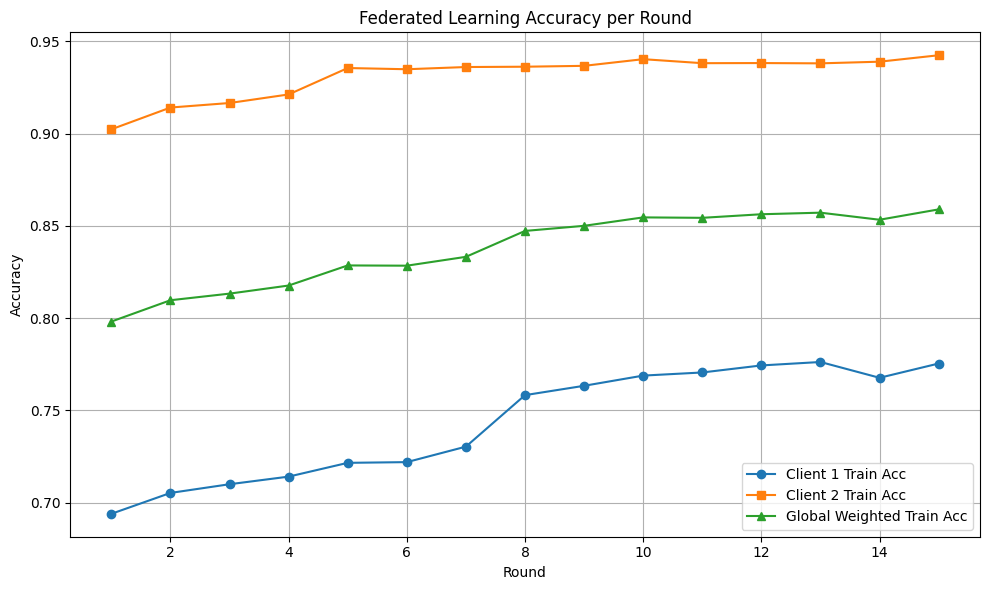

In [ ]:
results_df = pd.DataFrame(results, columns=['Round', 'Client1_Train_Acc', 'Client2_Train_Acc', 'Global_Train_Acc'])

# ----------------------------------------
# Plot accuracy trends
# ----------------------------------------
plt.figure(figsize=(10,6))
plt.plot(results_df['Round'], results_df['Client1_Train_Acc'], label='Client 1 Train Acc', marker='o')
plt.plot(results_df['Round'], results_df['Client2_Train_Acc'], label='Client 2 Train Acc', marker='s')
plt.plot(results_df['Round'], results_df['Global_Train_Acc'], label='Global Weighted Train Acc', marker='^')
plt.title('Federated Learning Accuracy per Round')
plt.xlabel('Round')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

1096/1096 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step
1096/1096 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
2192/2192 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


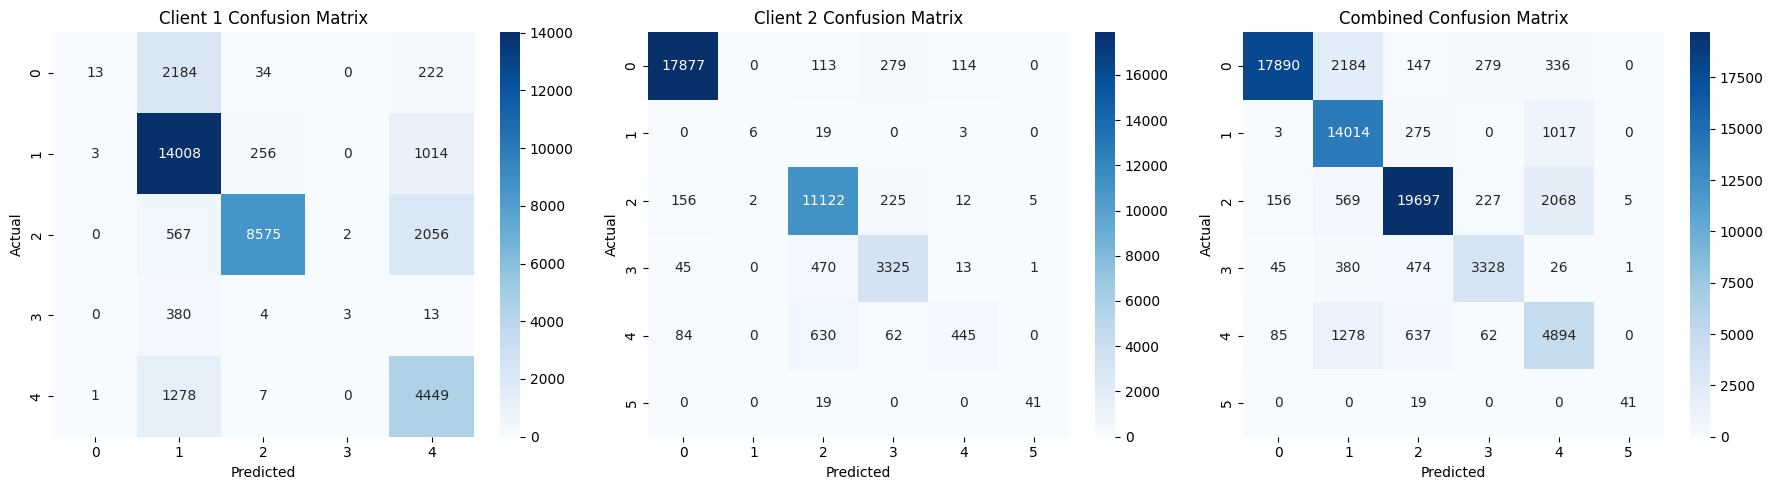

In [ ]:
import seaborn as sns
y_pred1 = np.argmax(global_model.predict(X1_test), axis=1)
y_pred2 = np.argmax(global_model.predict(X2_test), axis=1)
y_pred_all = np.argmax(global_model.predict(X_test_all), axis=1)

# Actual labels (already integers)
y_true1 = y1_test
y_true2 = y2_test
y_true_all = y_test_all

# Plot confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(18,5))
datasets = [
    ('Client 1', y_true1, y_pred1, axes[0]),
    ('Client 2', y_true2, y_pred2, axes[1]),
    ('Combined', y_true_all, y_pred_all, axes[2])
]

for name, y_true, y_pred, ax in datasets:
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title(f'{name} Confusion Matrix')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

print("\n Classification Report (Combined Test Data):")
print(classification_report(y_true_all, y_pred_all))


📘 Classification Report (Combined Test Data):
              precision    recall  f1-score   support

           0       0.98      0.86      0.92     20836
           1       0.76      0.92      0.83     15309
           2       0.93      0.87      0.90     22722
           3       0.85      0.78      0.82      4254
           4       0.59      0.70      0.64      6956
           5       0.87      0.68      0.77        60

    accuracy                           0.85     70137
   macro avg       0.83      0.80      0.81     70137
weighted avg       0.87      0.85      0.86     70137



In [ ]:
results_df.to_csv("federated_training_results.csv", index=False)
plt.savefig("federated_accuracy_curve.png", dpi=300)

# Save confusion matrices
for name, y_true, y_pred in [('Client1', y_true1, y_pred1),
                             ('Client2', y_true2, y_pred2),
                             ('Combined', y_true_all, y_pred_all)]:
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.savefig(f'{name}_confusion_matrix.png', dpi=300)
    plt.close()


<Figure size 640x480 with 0 Axes>

In [ ]:
files.download("federated_training_results.csv")
files.download("federated_accuracy_curve.png")
files.download("Client1_confusion_matrix.png")
files.download("Client2_confusion_matrix.png")
files.download("Combined_confusion_matrix.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
files.download("federated_accuracy_curve.png")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:


# Save only weights
global_model.save_weights("global_model_final.weights.h5")

# Save full model (architecture + weights)
global_model.save("global_model_full.h5")

print("✅ Global model weights and full model saved successfully!")

# Download both files
files.download("global_model_final.weights.h5")
files.download("global_model_full.h5")


✅ Global model weights and full model saved successfully!


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>